# 3. Preparação dos dados

Na seção anterior realizamos uma serie de analise descritiva dos dados com o intuito de entender a estrutura do dados e identificar as variáveis que podem ser usadas para prever se um cliente vai abandonar o banco ou continuar com ele.

Neste etapa, iremos realizar algumas transformações nos dados para que eles sejam adequados ao modelo preditivo.

Um ponto que deve ser ressaltado, temos dois banco de dados **Abandono_clientes.csv** e **Abandono_teste.csv**, o primeiro foi o banco de dados que usamos na etapa anterior e será este que iremos usar para treinar e testar o modelo. O segundo banco de dados, será utilizado apenas no final para avaliar o desempenho do modelo.

Para construção do nosso modelo utilizaremos o método de [Previsão Conforme](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-pr%C3%A1tica-%C3%A0-previs%C3%A3o-conforme-de4c7479e021), o objetivo de usar este método em conjunto com outros métodos preditivos é obter um nível de confiança estatística que nos permita avaliar o desempenho do nosso modelo. Desta forma, vamos poder quantificar a incerteza e avaliar o desempenho do nosso modelo.


Nesta fase iremos utilizar uma das principais bibliotecas no cenário de ciência de dados, o [scikit-lerarn](https://scikit-learn.org/) juntamente com os seus algoritmos de machine learning.


In [130]:
# Importando bibliotecas

# Manipulação de dados
import pandas as pd
import numpy as np 

# Visualização
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import HTML 
import plotly.graph_objects as go 
from pprint import pprint

# Algumas configurações
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuração para o notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    sns.set()

jupyter_settings()


# Machine Learning

# Processamento dos dados
from sklearn.model_selection import train_test_split , StratifiedKFold # Divisão dos dados em treino e teste
#from scipy import interp
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler # Codifica variáveis categóricas em valores numéricos.

# LabelEncoder, OneHotEncoder ->Codifica variáveis categóricas em valores numéricos.
# O primeiro identifica em número inteiro único e não altera a dimensionalidade, mas pode introduzir ordem artificial
# O segunda cada categoria é uma coluna binária e aumenta a dimensionalidade, mas não há ordem artificial
# Normaliza os dados numéricos para facilitar o treinamento dos modelos.
# RobustScaler ->
# MinMaxScaler -> 
from sklearn.compose import ColumnTransformer # Permite aplicar transformações diferentes para diferentes colunas
from sklearn.pipeline import Pipeline # Permite combinar múltiplas etapas do processo de machine learning


# Modelos de Machine Learning:
from sklearn.tree import DecisionTreeClassifier # Importa o classificador baseado em árvores de decisão.
from sklearn.ensemble import RandomForestClassifier # Importa o classificador baseado em florestas aleatórias.
from sklearn.naive_bayes import GaussianNB #  Importa o classificador Naive Bayes Gaussiano.
from sklearn.neighbors import KNeighborsClassifier # Importa o classificador K-Nearest Neighbors (KNN).
from sklearn.svm import SVC # Importa o classificador de Máquinas de Vetores de Suporte (SVM).
from sklearn.neural_network import MLPClassifier # Importa o classificador baseado em redes neurais artificiais (Perceptron Multicamadas).
from sklearn.ensemble import AdaBoostClassifier # Importa o classificador baseado em AdaBoost.
from sklearn.ensemble import GradientBoostingClassifier # Importa o classificador baseado em Gradient Boosting.
from sklearn.ensemble import ExtraTreesClassifier # Importa o classificador baseado em Árvores Extras (Extra Trees).
from xgboost import XGBClassifier #  Importa o classificador baseado no XGBoost, um algoritmo de Gradient Boosting otimizado.
from sklearn.linear_model import LogisticRegression # Importa o modelo de Regressão Logística.

# Métricas de desempenho
# Calcula a taxa de recuperação (recall).
# Calcula a curva ROC para análise de desempenho.
# Gera a matriz de confusão.
# Calcula a precisão do modelo
# Calcula a métrica F1, que é a média harmônica entre precisão e recall.
# Calcula a acurácia do modelo.
# Gera um relatório detalhado com precisão, recall e F1-score para cada classe.
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# salvar e carregar modelos
import joblib


Note que iremos remover as seguintes variáveis`RowNumber`', `CustomerId`, `Surname`, pois elas não tem papel nenhum na predição.

In [37]:
df_raw = pd.read_csv('../data/Abandono_clientes.csv', sep=',')
# Vamos fazer uma copia do dataset original

train_transform = df_raw.copy()
train_transform.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True) 
#  

Vamos separar os dados na variável algo $y=$ **Exited** e as variáveis preditoras $X$.

In [38]:
y = train_transform['Exited']

X = train_transform.drop('Exited', axis=1) 

Vamos dividir os dados da seguinte forma:

- 7000 amostras de dados ("`X_train`", "`y_train`") para treinar o modelo;
- 1000 amostras de dados ("`X_test`", "`y_test`") para avaliar o desempenho do modelo em dados "não vistos" no treinamento;
- 1000 amostras de dados ("`X_calib`"`y_calib`") para calibração em dados "não vistos" no treinamento;
- 1000 amostras restantes ("`X_new`"`y_new`") para etapa de previsão conforme e para sua avaliação.

Inicialmente iremos fazer esta distribuição, a depender dos resultados, podemos voltar e alterar estes valores

In [54]:
# Split dos dados em treino e teste
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=7000, random_state=2)

# Dos dados que sobraram, separando em dados de teste
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)

# Dos dados que sobraram, separando em calibração e new
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)




## 3.1 Definição de uma baseline

O intuito de criarmos uma baseline é para termos um ponto de partida ao avaliar o desempenho do nosso modelo. Iremos utilizar uma métrica que faz uso de Classificador de taxa aleatória (estimativa ponderada), para ver mais acesse o [artigo](https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f). Desta forma teremos a ZeroR baseline que a taxa mais frequente e a Random Rate (Baseline Ponderada) que é construída a seguir.

In [55]:
# Suponha que `y_train` contém os rótulos da variável alvo
# Cálculo das proporções de cada classe
proporcoes = np.bincount(y_train) / len(y_train)
p_minoritaria = proporcoes[1]  # Proporção da classe Exited = 1
p_majoritaria = proporcoes[0]  # Proporção da classe Exited = 0

# Cálculo das odds. Probabilidade de adivinhar corretamente com base nas proporções.
odds_minoria = p_minoritaria**2
odds_maioria = p_majoritaria**2

# Soma as odds ponderadas para cada classe para obter a precisão esperada de um classificador que adivinha com base nas proporções.
baseline = odds_minoria + odds_maioria

# Exibição dos resultados
print(f"Proporção da Classe Minoritária (Exited = 1): {p_minoritaria:.4f}")
print(f"Proporção da Classe Majoritária (Exited = 0): {p_majoritaria:.4f}")
print()
print(f"Odds de Adivinhar Corretamente a Classe Minoritária: {p_minoritaria}^2 = {odds_minoria:.4f}")
print(f"Odds de Adivinhar Corretamente a Classe Majoritária: {p_majoritaria}^2 = {odds_maioria:.4f}")
print()
print(f"Baseline Ponderado: {baseline:.4f} ou {baseline * 100:.2f}%")

Proporção da Classe Minoritária (Exited = 1): 0.2074
Proporção da Classe Majoritária (Exited = 0): 0.7926

Odds de Adivinhar Corretamente a Classe Minoritária: 0.20742857142857143^2 = 0.0430
Odds de Adivinhar Corretamente a Classe Majoritária: 0.7925714285714286^2 = 0.6282

Baseline Ponderado: 0.6712 ou 67.12%


Note que nossa Baseline Ponderada é de $67,12\%$ e a ZeroR Baseline é de $79,26\%$ estes valores serão os valores de avaliação inicial.

## 3.2 Transformação dos dados

Vamos fazer a separação das variáveis numéricas e categóricas. Decidi adicionar `HasCrCard`, `IsActiveMember` como variáveis categóricas, mesmo sendo números. No futuro posso voltar aqui e rever esta decisão. 

As transformações que vamos fazer são:

- **StandardScaler** para padronizar os valores, inicialmente não irei tratar os outliers, desejo ver como os modelos atual considerando esses valores, também não irei o min-max scaler para os valores que não possuem outliers.
- **OneHotEncoder** para transformar as variáveis categóricas do tipo `Gender` e `Geography` e valores binários. 

In [56]:
# Variáveis numéricas categóricas
categorical_numeric_features = ['HasCrCard', 'IsActiveMember', 'NumOfProducts']


# Variáveis numéricas contínuas
numeric_features = [col for col in X_train.select_dtypes(include=np.number).columns if col not in categorical_numeric_features]

# Variáveis categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist() + categorical_numeric_features

# Transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Pré-processador
preprocesso = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Criação do pipeline para conversão
preprocesso = ColumnTransformer(transformers= [('num', numeric_transformer, numeric_features),
                                            ('cat', categorical_transformer, categorical_features)])


# 4 Modelagem 

Vamos iniciar com as modelagens. Iremos criar uma lista com os seguintes modelos:

- LogisticRegression;
- DECISION TREE;
- KNeighbors;
- SCV;
- Random Forest;
- XGB;
- AdaBoost;
- ExtraTrees;
- GradientBoosting.

Iremos identificar quais aqueles que estão acima da nossa baseline, posteriormente, iremos selecionar os 3 melhores para polirmos.




In [57]:
# definindo uma lista de modelos
list_models = [('LOGISTIC REGRESSION', LogisticRegression(solver='lbfgs')),
               ('DECISION TREE', DecisionTreeClassifier()),
               ('KNN', KNeighborsClassifier()),
               ('SVC', SVC()),
               ('RANDOM FOREST', RandomForestClassifier(n_estimators=1000)),
               ('XGB', XGBClassifier(n_estimators=300, eval_metric='logloss', seed=42)),
               ('ABC', AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)),
               ('ExT', ExtraTreesClassifier()),
               ('GBC', GradientBoostingClassifier())
               ]

In [58]:
for name, model in list_models:
    clf = Pipeline(steps=[('preprocesso', preprocesso),
                          ('classificação', model)])
    
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test )

    print(name)
    print('-'*54)
    print('Treino', '\t', train_score)
    print('Validação', test_score, '\n')
    print(classification_report(y_test, clf.predict(X_test)))
    print('='*54, '\n')

LOGISTIC REGRESSION
------------------------------------------------------
Treino 	 0.842
Validação 0.846 

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       793
           1       0.73      0.40      0.52       207

    accuracy                           0.85      1000
   macro avg       0.80      0.68      0.71      1000
weighted avg       0.83      0.85      0.83      1000


DECISION TREE
------------------------------------------------------
Treino 	 1.0
Validação 0.829 

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       793
           1       0.58      0.60      0.59       207

    accuracy                           0.83      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.83      0.83      0.83      1000


KNN
------------------------------------------------------
Treino 	 0.8705714285714286
Validação 0.842 

              precision    reca

Nesta primeira rodada, os três melhores modelos foram, GBC com $88\%$ de acurácia seguido de XGB e FOREST com $87\%$ de acurácia. Estes resultados estão bem acima da nossa baseline ponderada de $67,12\%$ e da ZeroR Baseline é de $79,26\%$. 

## 4.1 Ajustando o modelo.

Inicialmente vamos utilizar mais dois tipos de processamentos nos dados. Quando realizamos a análise descritiva, notamos que alguns dados possuíam alguns outliers, vamos usar o `RobustScaler` para lidar com esses valores.

In [59]:
# Variáveis numéricas categóricas
categorical_numeric_features = ['HasCrCard', 'IsActiveMember', 'NumOfProducts']

# Variáveis numéricas contínuas
numeric_features = [col for col in X_train.select_dtypes(include=np.number).columns if col not in categorical_numeric_features]

# Variáveis para o RobustScaler
robust_scaler_features = ['Age', 'CreditScore', 'NumOfProducts']

# Variáveis para StandardScaler
standard_scaler_features = [col for col in numeric_features if col not in robust_scaler_features]


# Variáveis categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist() + categorical_numeric_features

# Transformadores
numeric_transformer_standard = StandardScaler()
numeric_transformer_robust = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# # Criação do pipeline para conversão

preprocesso = ColumnTransformer(transformers=[
    ('std_num', numeric_transformer_standard, standard_scaler_features),
    ('robust', numeric_transformer_robust, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [60]:
for name, model in list_models:
    clf = Pipeline(steps=[('preprocesso', preprocesso),
                          ('classificação', model)])
    
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test )

    print(name)
    print('-'*54)
    print('Treino', '\t', train_score)
    print('Validação', test_score, '\n')
    print(classification_report(y_test, clf.predict(X_test)))
    print('='*54, '\n')

LOGISTIC REGRESSION
------------------------------------------------------
Treino 	 0.8418571428571429
Validação 0.846 

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       793
           1       0.73      0.40      0.52       207

    accuracy                           0.85      1000
   macro avg       0.80      0.68      0.71      1000
weighted avg       0.83      0.85      0.83      1000


DECISION TREE
------------------------------------------------------
Treino 	 1.0
Validação 0.824 

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       793
           1       0.57      0.57      0.57       207

    accuracy                           0.82      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.82      0.82      0.82      1000


KNN
------------------------------------------------------
Treino 	 0.8697142857142857
Validação 0.836 

              prec

Realizar o tratamento dos Outliers não mudou significante os resultados, o motivo é devido os dados já estarem bem tratados, contendo poucos ou nenhum outliers.

Vimos que os três melhores modelos foram `GradientBoostingClassifier` seguido de `XGBClassifier` e `RandomForestClassifier`. Nesta fase iremos buscar ajustar estes modelos para obter um melhor resultado. 

## 4.2 RandomForestClassifier

Vamos iniciar o ajusto com o `RandomForestClassifier`.

In [61]:
# definindo um pipeline para Random Forest 
pipe_RF = Pipeline(steps=[('preprocesso', preprocesso),
                          ('clf', RandomForestClassifier(random_state=42))])

# Critério de separação 
criterio = ['gini', 'entropy']
# Queremos medir a qualidade da separação em cada nó
# gini -> Medição da impureza
# entropy -> mede a incerteza da separação

# Núm de arvores 
n_estimators = [200, 400, 600, 800, 1000, 1100, 1200, 1400, 1600, 1800, 2000]
# O uso de mais árvores ajuda a estabilidade

# Núm de variáveis em cada separação
max_features = ['auto', 'sqrt']
# auto usa todas as variáveis por padrão em classificadores
# sqrt usa a raiz quadrada do num total de variáveis
# O papel e reduzir o num de variáveis, diminuindo o overfitting

# Núm max de nível da árvore
max_depth = [10, 20, 30, 40, 60, 80, 90, 100, None]
# Controla a profundidade máxima das árvores. Obs. Árvores mais profundas capturam mais detalhes, mas podem causar overfitting

# Mín de amostras para dividir um nó
min_samples_split = [2, 5, 10]
# valores baixos permite divisões mais frequentes o que pode causar overfitting
# já valores autos limitam as divisões, tornando o modelo mais simples

# Min de amostra por fola
min_samples_leaf = [1, 2, 4]
# 1 Permite folhas individuais (mais propenso a overfitting).
#Valores mais altos: Tornam o modelo mais simples e robusto.

# Mét de seleção de amostras
bootstrap = [True, False]
# True: Usa amostragem com substituição (metodologia padrão de Random Forest).
# False: Usa todo o dataset sem substituição.

# Peso das classes 
class_weight = ['balanced', 'balanced_subsample', None]
# balanced: Calcula pesos automaticamente com base na proporção inversa das classes.
# balanced_subsample: Calcula pesos para cada árvore com base em sua amostra bootstrap.
# None: Não ajusta pesos.

grid_params_rf = [{'clf__criterion': criterio,
                   'clf__n_estimators': n_estimators,
                   'clf__max_features': max_features,
                   'clf__max_depth': max_depth,
                   'clf__min_samples_split': min_samples_split,
                   'clf__min_samples_leaf': min_samples_leaf,
                   'clf__bootstrap': bootstrap,
                   'clf__class_weight': class_weight
                   }]

pprint(grid_params_rf)

[{'clf__bootstrap': [True, False],
  'clf__class_weight': ['balanced', 'balanced_subsample', None],
  'clf__criterion': ['gini', 'entropy'],
  'clf__max_depth': [10, 20, 30, 40, 60, 80, 90, 100, None],
  'clf__max_features': ['auto', 'sqrt'],
  'clf__min_samples_leaf': [1, 2, 4],
  'clf__min_samples_split': [2, 5, 10],
  'clf__n_estimators': [200,
                        400,
                        600,
                        800,
                        1000,
                        1100,
                        1200,
                        1400,
                        1600,
                        1800,
                        2000]}]


Para aplicarmos os parâmetros podemos usar dois métodos, primeiro o `GridSearchCV` que fará todas as combinações possíveis dos hiperparâmetros do modelo ou `RandomizedSearchCV` no qual as combinações serão aleatórias. Vamos de segunda opção pois é menos custosa em tempo. 

In [62]:
# definido os parâmetros para o RandomizedSearchCV
RFC_RandomSearch = RandomizedSearchCV(estimator=pipe_RF, 
                                      param_distributions=grid_params_rf, 
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=2, 
                                      random_state=42, 
                                      n_jobs = -1)

# treinando o modelo randomico
RFC_RandomSearch.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END clf__bootstrap=True, clf__class_weight=balanced, clf__criterion=gini, clf__max_depth=60, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=600; total time=   0.0s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__criterion=entropy, clf__max_depth=10, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200; total time=   0.0s
[CV] END clf__bootstrap=False, clf__class_weight=balanced, clf__criterion=gini, clf__max_depth=90, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400; total time=   0.0s
[CV] END clf__bootstrap=False, clf__class_weight=balanced, clf__criterion=gini, clf__max_depth=90, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=1400; total time=   0.0s
[CV] END clf__bootstrap=True, clf__class_weight=balanced, cl

/home/mhpedro/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__bootstrap=True, clf__class_weight=None, clf__criterion=gini, clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=1100; total time=  18.1s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__criterion=gini, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=800; total time=   0.1s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__criterion=gini, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=800; total time=   0.0s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__criterion=entropy, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=1200; total time=   0.0s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__criterion=entropy, clf__max_depth=None, clf__max_features=auto, clf__min_samples_l

/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
126 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesso',
                                              ColumnTransformer(transformers=[('std_num',
                                                                               StandardScaler(),
                                                                               ['Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('robust',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Geography',
                                                                                'Gender',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'Nu...
                   param_distributions=[{'clf__bootstrap': [True, False],
                                         'clf__class_weight': ['balanced',
                                                               'balanced_subsample',
                                                               None],
                                         'clf__criterion': ['gini', 'entropy'],
                                         'clf__max_depth': [10, 20, 30, 40, 60,
                                                            80, 90, 100, None],
                                         'clf__max_features': ['auto', 'sqrt'],
                                         'clf__min_samples_leaf': [1, 2, 4],
                                         'clf__min_samples_split': [2, 5, 10],
                                         'clf__n_estimators': [200, 400, 600,
                                                               800, 1000, 1100,
                                                               1200, 1400, 1600,
                                                               1800, 2000]}],
                   random_state=42, verbose=2)

In [63]:
# Vamos verificar os melhores hiperparâmetros obtidos pelo RandomizedSearch
RFC_RandomSearch.best_params_


{'clf__n_estimators': 1100,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 1,
 'clf__max_features': 'sqrt',
 'clf__max_depth': None,
 'clf__criterion': 'gini',
 'clf__class_weight': None,
 'clf__bootstrap': True}

In [64]:
# definindo um objeto com os melhores estimadores encontrados
best_random_RF = RFC_RandomSearch.best_estimator_

# Agora vamos treinar nosso modelo
best_random_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_estimators=1100,
                                        random_state=42))])

Vamos checar o resultado deste novo treinamento

In [65]:
# Checando os resultados com dados treino (acuraria) e validação (acuraria e outros)

train_score_RF = best_random_RF.score(X_train, y_train)
test_score_RF = best_random_RF.score(X_test, y_test)
print('train','\t ',train_score_RF)
print('validação', test_score_RF,'\n')
print(classification_report(y_test, best_random_RF.predict(X_test)))


train 	  0.9324285714285714
validação 0.874 

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       793
           1       0.81      0.51      0.63       207

    accuracy                           0.87      1000
   macro avg       0.85      0.74      0.78      1000
weighted avg       0.87      0.87      0.86      1000



Interpretação Geral

1. Acurácia (Train: $93\%$, Validação: $87.4\%$):

    - O modelo tem um desempenho muito bom no conjunto de treino, mas sua acurácia cai no conjunto de validação.
    - Essa diferença ($93.2\%$ vs $87.4\%$) pode indicar overfitting, onde o modelo está memorizando os dados de treino e não generalizando bem para novos dados.

2. Métricas por Classe (Precision, Recall e F1-Score):

    - Classe $0$ (Majoritária):
        - Precisão: $88\%$ das previsões de classe $0$ estão corretas.
        - Recall: $97\%$ dos casos reais de classe $0$ foram corretamente identificados como $0$.
        - F1-Score: $92\%$, indicando bom equilíbrio entre precisão e recall para essa classe.
    - Classe 1 (Minoritária):
        - Precisão: $81\%$ das previsões de classe $1$ estão corretas.
        - Recall: Apenas $51\%$ dos casos reais de classe $1$ foram identificados corretamente. Isso mostra que o modelo está deixando de prever corretamente muitos casos de classe $1$.
        - F1-Score: $63\%$, menor do que a classe $0$, refletindo a dificuldade do modelo em lidar com a classe minoritária.

3. Médias (Macro e Weighted Avg):

    - Macro Avg: Média simples das métricas das duas classes.
        - Precision: $85\%$
        - Recall: $74\%$ (baixa devido ao recall da classe $1$).
        - F1-Score: $78\%$
    - Weighted Avg: Média ponderada pelo número de instâncias em cada classe.
        - Valores similares à classe majoritária devido ao desbalanceamento dos dados.

Um problemas que notamos é devido ao desbalanceamento das classes, temos muito mais valores para classe $0$ que para classe $1$, provavelmente temos um problema de overfitting.

Vamos tentar nos aprofundar e analisar mais duas métricas, a curva ROC e a Precision Recall. Para tal, vamos criar um objeto Kfold, para separar o dataset em 5 partes e em seguida criar uma função para rodar o modelo com essas 5 partes amostrais do conjunto e analisar os resultados.

In [66]:
# criando um objeto com stratified kfold
StratifKfold_RF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [67]:
# criando uma função para plotar o gráfico
def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    # definindo algumas listas vazias para receber o resultado
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # definindo o contador
    i = 0
    fig = plt.figure( figsize=(10, 5))  

    # loop ara validação cruzada
    for train, test in cv.split(X, y):
        
        # executando a função e armazenando as probabilidade dos resultados
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        
        # computando a curva ROC e AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # plotando a curva ROC da validação cruzada em individualmente
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    
    
    # plotando a linha diagonal como referência da taxa de 50/50
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # calculando as médias e desvio padrão
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # plotando curva ROC com a média dos resultados
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.show()

    

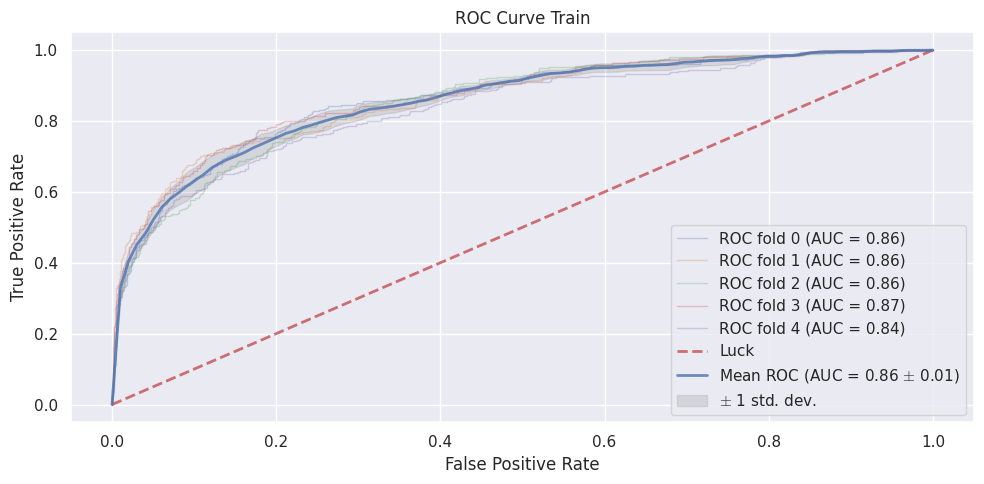

In [68]:
draw_cv_roc_curve(best_random_RF, StratifKfold_RF, X_train, y_train, title='ROC Curve Train')

O melhor resultado é termos nossa curva o pais à esquerda e no topo. O Nosso modelo tem $86\%$ probabilidade de classificar corretamente uma amostra positiva com mais provável do que uma mostra negativa e com um desvio padrão de $\pm 1$.

Um ponto importante é o fato que a ROC Curve não é impactada por classes desbalanceadas.


Vamos analisar a Precision-Recall Curve que tem como papel medir a proporção de predições positivas corretas em relação ao total de predições positivas feitas pelo modelo.

In [69]:
# criando uma função para plotar o gráfico
def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    # definindo algumas listas vazias para receber o resultado
    y_real = []
    y_proba = []

    # definindo o contador
    i = 0
    
    fig = plt.figure( figsize=(10, 5))  

    # loop ara validação cruzada
    for train, test in cv.split(X, y):
        
        # executando a função e armazenando as probabilidade dos resultados
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        
        
        # computando a curva ROC e AUC
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])

        # plotando a Precision-Recall da validação cruzada em individualmente
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))

        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    # concatenando os valores da lista
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)

    # calculando a Precision-Recall
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    
    # plotando as médias dos resultados
    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    # customizando o gráfico
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title)
    plt.legend(loc="lower right")
    
    # exibindo o gráfico
    plt.show()

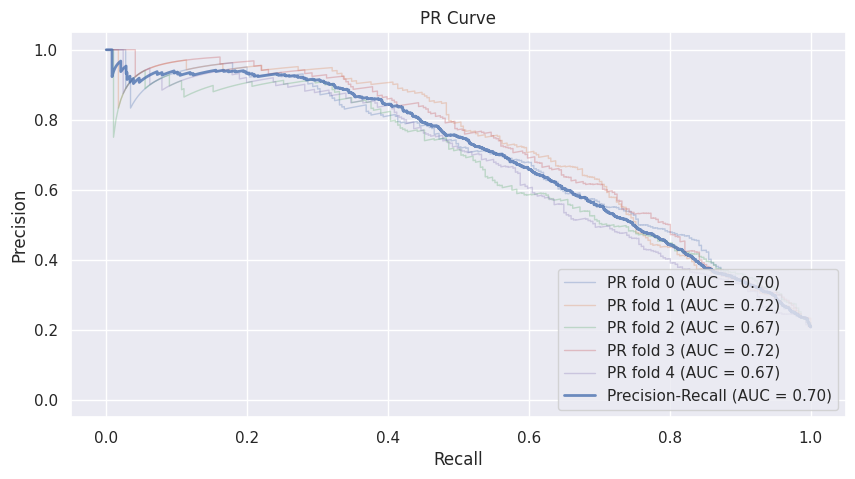

In [70]:
# executando função e plotando a Curva Precision-Recall
draw_cv_pr_curve(best_random_RF, StratifKfold_RF, X_train, y_train, title='PR Curve')

O melhor resultado possível é quando temos uma curva próxima ao canto superior direito, indicando alta precision e recall.
AUC-PR (Área sob a curva):

A média da AUC-PR é $70\%$, o que indica desempenho razoável, contudo não é o melhor cenário.

O desempenho varia ligeiramente entre os folds, com AUCs entre $67\%$ e $72\%$. Isso sugere que o modelo é relativamente estável, mas pode ser sensível aos dados do treinamento/validação.

É importante notar que a curva tem queda acentuada em recall alto, indicando que, para capturar mais positivos, a precision cai rapidamente. Isso pode ser um problema se você precisar de alta sensibilidade.

Vamos colocar nosso modelo para jogo e ver como ele se comporta usando todo os dados:

In [93]:
best_random_RF.fit(X, y)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_estimators=1100,
                                        random_state=42))])

In [94]:
print(classification_report(y, best_random_RF.predict(X)))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7963
           1       0.96      0.71      0.81      2037

    accuracy                           0.93     10000
   macro avg       0.94      0.85      0.89     10000
weighted avg       0.93      0.93      0.93     10000



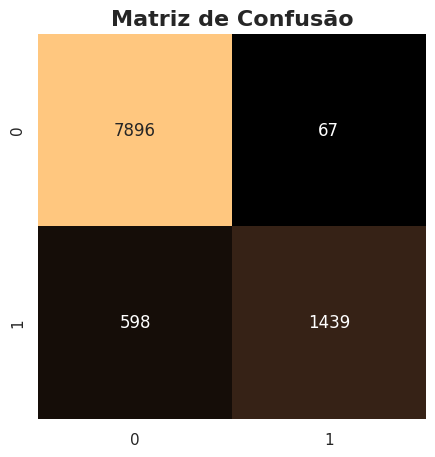

In [95]:
# definindo a área de plotagem
plt.figure(figsize=(5,5))

# plotando o gráfico
sns.heatmap(confusion_matrix(y, best_random_RF.predict(X)), annot=True, cmap=plt.cm.copper, fmt='g', cbar=False)
plt.title("Matriz de Confusão", fontsize=16, fontweight='bold')

# exibindo o gráfico
plt.show()

Nos dados de treino o modelo acertou $93\%$%, agora precisamos analisar se não haverá muita diferença em um conjunto que o modelo não conhece, ou seja, a possibilidade de overfitting.

## 4.3 XGBClassifier

In [96]:
# Definindo o pipeline para XGBoost
pipe_XGB = Pipeline(steps=[('preprocesso', preprocesso),
                           ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))])

# Parâmetros para o grid search
# Taxa de aprendizado
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
# Controla o tamanho dos passos de atualização dos pesos. Taxas mais baixas tornam o treinamento mais lento, mas podem melhorar a performance.

# Número de árvores
n_estimators = [200, 400, 600, 800, 1000, 1200]
# Número de árvores de decisão a serem treinadas. Mais árvores geralmente aumentam a estabilidade, mas aumentam o tempo de treinamento.

# Profundidade máxima das árvores
max_depth = [3, 5, 10, 15, None]
# Controla a profundidade máxima das árvores. Árvores mais profundas capturam mais detalhes, mas podem causar overfitting.

# Subsample
subsample = [0.6, 0.8, 1.0]
# Define a proporção de amostras utilizadas para treinar cada árvore. Valores menores ajudam a reduzir o overfitting.

# Colsample_bytree
colsample_bytree = [0.6, 0.8, 1.0]
# Define a proporção de variáveis utilizadas por árvore. Valores menores ajudam a reduzir o overfitting.

# Regularização L1 e L2
reg_alpha = [0, 0.01, 0.1, 1, 10]
reg_lambda = [1, 10, 100]
# Adiciona penalidades para regularizar os coeficientes (L1 = sparsidade, L2 = prevenir overfitting).

# Gamma (min_split_loss)
gamma = [0, 0.1, 0.3, 0.5]
# Controla a redução mínima de perda para realizar uma divisão. Valores maiores tornam o modelo mais conservador.

# Taxa de aprendizado adaptada para overfitting
scale_pos_weight = [1, 2, 5, 10]
# Usado para lidar com classes desbalanceadas. Dá mais peso à classe minoritária.

# Definindo o grid para o XGBClassifier
grid_params_xgb = [{'clf__learning_rate': learning_rate,
                    'clf__n_estimators': n_estimators,
                    'clf__max_depth': max_depth,
                    'clf__subsample': subsample,
                    'clf__colsample_bytree': colsample_bytree,
                    'clf__reg_alpha': reg_alpha,
                    'clf__reg_lambda': reg_lambda,
                    'clf__gamma': gamma,
                    'clf__scale_pos_weight': scale_pos_weight}]

# Imprimindo os parâmetros definidos
pprint(grid_params_xgb)


[{'clf__colsample_bytree': [0.6, 0.8, 1.0],
  'clf__gamma': [0, 0.1, 0.3, 0.5],
  'clf__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
  'clf__max_depth': [3, 5, 10, 15, None],
  'clf__n_estimators': [200, 400, 600, 800, 1000, 1200],
  'clf__reg_alpha': [0, 0.01, 0.1, 1, 10],
  'clf__reg_lambda': [1, 10, 100],
  'clf__scale_pos_weight': [1, 2, 5, 10],
  'clf__subsample': [0.6, 0.8, 1.0]}]


In [97]:
# definido os parâmetros para o RandomizedSearchCV
XGB_RandomSearch = RandomizedSearchCV(estimator=pipe_XGB, 
                                      param_distributions=grid_params_xgb, 
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=0, 
                                      random_state=42, 
                                      n_jobs = -1)

# treinando o modelo randomico
XGB_RandomSearch.fit(X, y)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesso',
                                              ColumnTransformer(transformers=[('std_num',
                                                                               StandardScaler(),
                                                                               ['Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('robust',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Geography',
                                                                                'Gender',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'Nu...
                   param_distributions=[{'clf__colsample_bytree': [0.6, 0.8,
                                                                   1.0],
                                         'clf__gamma': [0, 0.1, 0.3, 0.5],
                                         'clf__learning_rate': [0.01, 0.05, 0.1,
                                                                0.2, 0.3],
                                         'clf__max_depth': [3, 5, 10, 15, None],
                                         'clf__n_estimators': [200, 400, 600,
                                                               800, 1000,
                                                               1200],
                                         'clf__reg_alpha': [0, 0.01, 0.1, 1,
                                                            10],
                                         'clf__reg_lambda': [1, 10, 100],
                                         'clf__scale_pos_weight': [1, 2, 5, 10],
                                         'clf__subsample': [0.6, 0.8, 1.0]}],
                   random_state=42)

In [98]:
# Verificando os melhores hiperparâmetros obtidos pelo RandomizedSearch
XGB_RandomSearch.best_params_

{'clf__subsample': 0.6,
 'clf__scale_pos_weight': 1,
 'clf__reg_lambda': 1,
 'clf__reg_alpha': 0.01,
 'clf__n_estimators': 1200,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__gamma': 0.3,
 'clf__colsample_bytree': 1.0}

In [99]:
# definindo um objeto com os melhores estimadores encontrados
best_random_XGB = XGB_RandomSearch.best_estimator_

# Agora vamos treinar nosso modelo
best_random_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 XGBClassi...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [100]:
# Checando os resultados com dados treino (acuraria) e validação (acuraria e outros)

train_score_XGB = best_random_XGB.score(X_train, y_train)
test_score_XGB = best_random_XGB.score(X_test, y_test)
print('train','\t ',train_score_XGB)
print('validação', test_score_XGB,'\n')
print(classification_report(y_test, best_random_XGB.predict(X_test)))


train 	  0.8757142857142857
validação 0.878 

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       793
           1       0.81      0.53      0.64       207

    accuracy                           0.88      1000
   macro avg       0.85      0.75      0.78      1000
weighted avg       0.87      0.88      0.87      1000



Interpretação Geral

Esta nova versão do XGB com os hiperparâmetros teve um sutil melhora ao compararmos com a sua versão anterior, antes o valor de acurácia era de $87\%$ e fomos agora para $88\%$. Comparado com o RandomFlorets, o considero melhor, pois a acurácia na base de treino é maior comparado com o XGB. Os demais resultados são bastante semelhantes ao RandomFloret.

Colocando o XGB para jogo e aprendendo com toda a base de dados:

In [102]:
best_random_XGB.fit(X, y)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 XGBClassi...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [103]:
print(classification_report(y, best_random_XGB.predict(X)))


              precision    recall  f1-score   support

           0       0.89      0.97      0.92      7963
           1       0.80      0.51      0.62      2037

    accuracy                           0.87     10000
   macro avg       0.84      0.74      0.77     10000
weighted avg       0.87      0.87      0.86     10000



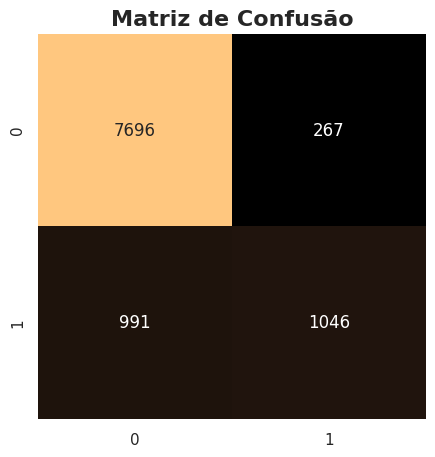

In [104]:
# definindo a área de plotagem
plt.figure(figsize=(5,5))

# plotando o gráfico
sns.heatmap(confusion_matrix(y, best_random_XGB.predict(X)), annot=True, cmap=plt.cm.copper, fmt='g', cbar=False)
plt.title("Matriz de Confusão", fontsize=16, fontweight='bold')

# exibindo o gráfico
plt.show()

## 4.3 GradientBoostingClassifier

Por ultimo vamos, analisar o GradientBoosting.

In [105]:
# Definindo o pipeline para Gradient Boosting
pipe_GB = Pipeline(steps=[('preprocesso', preprocesso),
                          ('clf', GradientBoostingClassifier(random_state=42))])

# Parâmetros para o grid search

# Taxa de aprendizado
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
# Controla a magnitude de ajuste em cada iteração. Valores baixos combinados com mais estimadores geralmente resultam em melhor desempenho.

# Número de estimadores
n_estimators = [100, 200, 300, 400, 500]
# Número de árvores a serem treinadas. Mais árvores aumentam a estabilidade, mas podem elevar o tempo de treinamento.

# Profundidade máxima das árvores
max_depth = [3, 5, 10, None]
# Define a profundidade máxima das árvores. Profundidades maiores capturam padrões complexos, mas podem causar overfitting.

# Subsample
subsample = [0.6, 0.8, 1.0]
# Define a proporção de amostras usadas para treinar cada árvore. Usar uma fração menor ajuda a reduzir overfitting.

# Número mínimo de amostras para divisão de nó
min_samples_split = [2, 5, 10]
# O número mínimo de amostras necessário para dividir um nó. Valores maiores tornam o modelo mais conservador.

# Número mínimo de amostras por folha
min_samples_leaf = [1, 2, 4, 10]
# Define o número mínimo de amostras que cada nó folha deve ter. Valores maiores ajudam a evitar overfitting.

# Máximo de variáveis consideradas para divisão
max_features = ['auto', 'sqrt', 'log2', None]
# Define o número de variáveis consideradas para encontrar a melhor divisão.

# Critério de perda
loss = ['log_loss', 'exponential']
# Define a função de perda usada para otimização. `log_loss` é padrão para classificação binária, `exponential` é usado para imitar AdaBoost.

# Definindo o grid para o GradientBoostingClassifier
grid_params_gb = [{'clf__learning_rate': learning_rate,
                   'clf__n_estimators': n_estimators,
                   'clf__max_depth': max_depth,
                   'clf__subsample': subsample,
                   'clf__min_samples_split': min_samples_split,
                   'clf__min_samples_leaf': min_samples_leaf,
                   'clf__max_features': max_features,
                   'clf__loss': loss}]

# Imprimindo os parâmetros definidos
pprint(grid_params_gb)


[{'clf__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
  'clf__loss': ['log_loss', 'exponential'],
  'clf__max_depth': [3, 5, 10, None],
  'clf__max_features': ['auto', 'sqrt', 'log2', None],
  'clf__min_samples_leaf': [1, 2, 4, 10],
  'clf__min_samples_split': [2, 5, 10],
  'clf__n_estimators': [100, 200, 300, 400, 500],
  'clf__subsample': [0.6, 0.8, 1.0]}]


In [106]:
# definido os parâmetros para o RandomizedSearchCV
GB_RandomSearch = RandomizedSearchCV(estimator=pipe_GB, 
                                      param_distributions=grid_params_gb, 
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=0, 
                                      random_state=42, 
                                      n_jobs = -1)

# treinando o modelo randomico
GB_RandomSearch.fit(X, y)

/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
93 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mhpedro/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", l

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesso',
                                              ColumnTransformer(transformers=[('std_num',
                                                                               StandardScaler(),
                                                                               ['Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('robust',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'EstimatedSalary']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Geography',
                                                                                'Gender',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'Nu...
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'clf__learning_rate': [0.01, 0.05, 0.1,
                                                                0.2, 0.3],
                                         'clf__loss': ['log_loss',
                                                       'exponential'],
                                         'clf__max_depth': [3, 5, 10, None],
                                         'clf__max_features': ['auto', 'sqrt',
                                                               'log2', None],
                                         'clf__min_samples_leaf': [1, 2, 4, 10],
                                         'clf__min_samples_split': [2, 5, 10],
                                         'clf__n_estimators': [100, 200, 300,
                                                               400, 500],
                                         'clf__subsample': [0.6, 0.8, 1.0]}],
                   random_state=42)

In [110]:
# Verificando os melhores hiperparâmetros obtidos pelo RandomizedSearch
GB_RandomSearch.best_params_

{'clf__subsample': 0.8,
 'clf__n_estimators': 300,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__max_features': None,
 'clf__max_depth': 5,
 'clf__loss': 'log_loss',
 'clf__learning_rate': 0.01}

In [111]:
# definindo um objeto com os melhores estimadores encontrados
best_random_GB = GB_RandomSearch.best_estimator_

# Agora vamos treinar nosso modelo
best_random_GB.fit(X_train, y_train)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=300, random_state=42,
                                            subsample=0.8))])

In [112]:
# Checando os resultados com dados treino (acuraria) e validação (acuraria e outros)

train_score_GB = best_random_GB.score(X_train, y_train)
test_score_GB = best_random_GB.score(X_test, y_test)
print('train','\t ',train_score_GB)
print('validação', test_score_GB,'\n')
print(classification_report(y_test, best_random_GB.predict(X_test)))

train 	  0.8781428571428571
validação 0.88 

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       793
           1       0.85      0.51      0.64       207

    accuracy                           0.88      1000
   macro avg       0.87      0.74      0.78      1000
weighted avg       0.88      0.88      0.87      1000



Interpretação Geral

Na base de treino e teste, notamos que o desempenho ao usarmos os hiperparâmetros também não resultou uma melhoria no modelo GradientBoosting.

Vamos colocar agora o GB para jogo e treinar com todo o banco de dados.

In [113]:
best_random_GB.fit(X, y)

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=300, random_state=42,
                                            subsample=0.8))])

In [114]:
print(classification_report(y, best_random_GB.predict(X)))


              precision    recall  f1-score   support

           0       0.88      0.97      0.93      7963
           1       0.83      0.49      0.62      2037

    accuracy                           0.88     10000
   macro avg       0.86      0.73      0.77     10000
weighted avg       0.87      0.88      0.86     10000



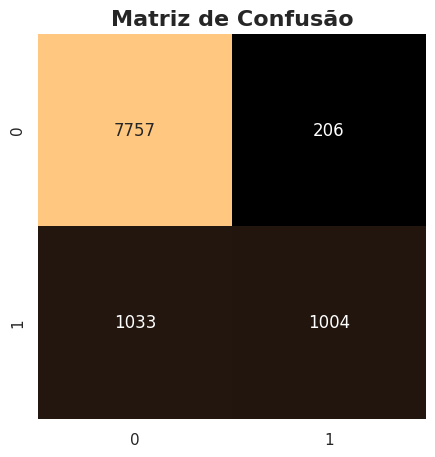

In [115]:
# definindo a área de plotagem
plt.figure(figsize=(5,5))

# plotando o gráfico
sns.heatmap(confusion_matrix(y, best_random_GB.predict(X)), annot=True, cmap=plt.cm.copper, fmt='g', cbar=False)
plt.title("Matriz de Confusão", fontsize=16, fontweight='bold')

# exibindo o gráfico
plt.show()

In [116]:
# Sumarizando os resultados dos modelos treinando na base completa


# Estrutura de resultados com nomes dos modelos e classificadores
resultados = [
    ("Random Forest", best_random_RF),
    ("XGBoost", best_random_XGB),
    ("Gradient Boosting", best_random_GB)
]

# Lista para armazenar os resultados
dados_resultados = []

# Loop para calcular e armazenar os resultados
for name, clf in resultados:
    clf.fit(X, y)  # Treinamento do modelo

    train_score = clf.score(X, y)  # Score no treino
    test_score = clf.score(X, y)  # Score na validação

    y_pred = clf.predict(X)  # Previsões no teste
    class_report = classification_report(y, y_pred, output_dict=True)  # Relatório de classificação como dicionário

    # Armazenando os resultados
    dados_resultados.append({
        "Modelo": name,
        "Train Score": train_score,
        "Test Score": test_score,
        "Precision (Class 0)": class_report['0']['precision'],
        "Recall (Class 0)": class_report['0']['recall'],
        "F1-Score (Class 0)": class_report['0']['f1-score'],
        "Precision (Class 1)": class_report['1']['precision'],
        "Recall (Class 1)": class_report['1']['recall'],
        "F1-Score (Class 1)": class_report['1']['f1-score'],
        "Accuracy": class_report['accuracy']
    })

# Criando o DataFrame
modelo_metrica_resultados = pd.DataFrame(dados_resultados)


## 4.4 Recapitulando e Conclusões

Nesta fase 4 buscamos construir o nosso modelo. Iniciamos com uma lista de modelos mais usados pela comunidade de DS e comparamos com a nossa baseline definida na fase 3. Observamos que todos os modelos iniciais da nossa lista estavam acima da baseline, este resultado em parte é bom, pois indica que os modelos inicialmente atual melhor que o ponto de partida que estabelecemos, contudo poderíamos construir um ponto de partida mais rigoroso.

É importante ressaltar que primeira rodada usamos algumas técnicas de transformações: `StandardScaler` para normalizar os valores numéricos e o `OneHotEnconder` para transformar as variáveis categóricas do tipo objeto em valores binários. 

Na segunda rodada, adicionamos o `RobustScaler` para lidar com os outliers e separamos varamos as variáveis categóricas numéricas das outras variáveis numéricas. Notamos o resultado da acurácia não alterou significativamente.

Continuando com o objetivo de ajustar os melhores modelos, busquei escolher os 3 modelos com base nos melhores valores de melhor acurácia, são eles: `RandomForestClassifier`, `XGBClassifier` que oberam $87\%$ de acurácia e o `GradientBoostingClassifier` que obteve $88\%$ de acurácia.

Olhando modelo por modelo com o objetivo de identificar os melhores hiperparâmetros, os resultados sumarizados podem ser visto na tabela a seguir:

In [117]:
modelo_metrica_resultados.head()

,Modelo,Train Score,Test Score,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Accuracy
0,Random Forest,0.9335,0.9335,0.929597,0.991586,0.959592,0.955511,0.706431,0.812306,0.9335
1,XGBoost,0.8742,0.8742,0.885921,0.966470,0.924444,0.796649,0.513500,0.624478,0.8742
2,Gradient Boosting,0.8761,0.8761,0.882480,0.974130,0.926043,0.829752,0.492882,0.618417,0.8761


Quando os modelos treinam com todos os dados, notamos que o Random Forest consegue melhorar muito sua capacidade. Este modelo consegue tirar proveito do aumento da base de dados, já os outros dois modelos não tiveram um aumento significativo. 

É importante notar também que ao usar todo o banco de dados, conseguiu melhorar as previsões da Classe $1$, o que é um ótimo resultado. 
Iniciamos com uma baseline de $67.12\%$, obtendo $87.63\%$ ao usar os melhores hiperparâmetros e agora com toda a base de dados chegamos em $93\%$ de acurácia.

# 5. Salvando o modelo

Nesta fase iremos organizar a gestão do modelo para podermos utilizarmos na faze final.
Iremos colocar estes modelos finais em um script python para podermos usar como experimento no MLFlow, assim conseguiremos monitorar o desempenho dos nossos modelos e decidir quem vai para  produção.

Para simularmos um ambiente empresarial que possui um servido, teremos um environment chamado `mlflow_env` que irá atuar como o nosso servidor.

Para inicializar o nosso mlflow devemos fazer:

```Bash
mlflow server --host 127.0.0.1 --port 8080
```
Entrando por meio do link http://127.0.0.1:8080, temos acesso ao Mlflow.

Dentro do Mlflow, criamos um modelo chamado **Churn-Abandono** e nosso primeiro experimento **churn_pedro_indicium**

